In [1]:
import gym

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
h1 = 400
h2 = 300
EPS = 0.03
EPS_DECAY = 0.001
EPSILON_MIN = 0.001
EPSILON = 1.0
batch_size = 128
n_episode = 200
max_step = 1000
tau = 0.001
lr_c = 0.001
lr_a = 0.0001
gamma = 0.99
memory_capacity = 100000

env = gym.make('Pendulum-v0')
N_actions = env.action_space.shape[0]
Actions_lim = env.action_space.high[0]
N_states = env.observation_space.shape[0] #3 state space (1,0)

C:\Users\K\anaconda3\envs\virenv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
class ReplayBuffer(object):
    def __init__(self, buffer_size, random_seed = 123):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = []
        random.seed(random_seed)
        
    def add(self,s,a,r,t,s2):
        experience = (s,a,r,t,s2)
        if self.count<=self.buffer_size:
            self.buffer.append(experience)
            self.count +=1
        else:
            self.buffer.pop(0)
            self.buffer.append(experience)
    
    def size(self):
        return self.count
    
    
    def sample_batch(self, batch_size):
        if self.count < batch_size :
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)
        
        s_batch = np.array([e[0] for e in batch]) #np array(batch_size,3)
        a_batch = np.array([e[1] for e in batch]) #np array(batch_size, 1)
        r_batch = np.array([e[2] for e in batch]) #np array(batch_size, )
        t_batch = np.array([e[3] for e in batch]) #np array(batch_size, )
        s2_batch = np.array([e[4] for e in batch])#np array(batch_size, 3)
        
        return s_batch, a_batch, r_batch, t_batch, s2_batch
    
    def clear(self):
        self.buffer = []
        self.count = 0        

In [10]:
class OUNoise:
    
    def __init__(self, action_dimension, mu = 0, theta = 0.15, sigma = 0.2):
        self.action_dimension = action_dimension
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()
    
    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu
        
    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x+dx
        return self.state

In [16]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        
        self.fc1 = nn.Linear(N_states,h1)
        self.fc1.weight.data.normal_(0,0.1)
        
        self.fc2 = nn.Linear(h1 + N_actions, h2)
        self.fc2.weight.data.normal_(0, 0.1)
        
        self.fc3 = nn.Linear(h2, 1)
        self.fc3.weight.data.uniform_(-EPS, EPS)
        
        self.relu = nn.ReLU()
    
    def forward(self, state, action):
        s1 = self.relu(self.fc1(state))
        x = torch.cat((s1,action), dim = 1)
        x = self.relu(self.fc2(x))
        action_value = self.fc3(x)
        return action_value

In [12]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        
        self.fc1 = nn.Linear(N_states, h1)
        self.fc1.weight.data.normal_(0,0.1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc2.weight.data.normal_(0,0.1)
        self.fc3 = nn.Linear(h2, N_actions)
        self.fc3.weight.data.uniform_(-EPS,EPS)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, state):
        
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        action = self.tanh(self.fc3(x)) * Actions_lim
        return action

In [35]:
class DDPG(object):
    def __init__(self):
        self.is_training = True
        self.epsilon = EPSILON
        self.eps_decay = EPS_DECAY
        self.randomer = OUNoise(N_actions)
        self.buffer = ReplayBuffer(memory_capacity)
        
        self.actor = Actor()
        self.actor_target = Actor()
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr = lr_a)
        
        self.critic = Critic()
        self.critic_target = Critic()
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = lr_c)
        
        self.hard_update(self.actor_target, self.actor)
        self.hard_update(self.critic_target, self.critic)
        
    def select_action(self, state):
        state = torch.tensor(state,dtype = torch.float).unsqueeze(0)
        
        action = self.actor(state).detach()
        action = action.squeeze(0).numpy()
        action += self.is_training * max(EPSILON, EPSILON_MIN) * self.randomer.noise()
        action = np.clip(action,-Actions_lim, Actions_lim)
        
        self.action = action
        
        return action
    
    def learn(self):
        s1, a1, r1, t1, s2 =self.buffer.sample_batch(batch_size)
        
        t1 = (t1 == False) * 1
        s1 = torch.tensor(s1, dtype = torch.float)
        a1 = torch.tensor(a1, dtype = torch.float)
        r1 = torch.tensor(r1, dtype = torch.float)
        t1 = torch.tensor(t1, dtype = torch.float)
        s2 = torch.tensor(s2, dtype = torch.float)
        
        a2 = self.actor_target(s2).detach()
        target_q = self.critic_target(s2, a2).detach()
        y_expected = r1[:,None] + t1[:,None] * gamma * target_q #r1[:,None]=> (batch_size,1)
        y_predicted = self.critic.forward(s1, a1)
        
        critic_loss = nn.MSELoss()
        loss_critic = critic_loss(y_predicted, y_expected)
        self.critic_optimizer.zero_grad()
        loss_critic.backward()
        self.critic_optimizer.step()
        
        pred_a = self.actor.forward(s1)
        loss_actor = (-self.critic.forward(s1,pred_a)).mean()
        self.actor_optimizer.zero_grad()
        loss_actor.backward()
        self.actor_optimizer.step()
        
        self.soft_update(self.actor_target, self.actor, tau)
        self.soft_update(self.critic_target, self.critic, tau)
        
        return loss_actor.item(), loss_critic.item()
        
    def soft_update(self, target, source, tau = 0.001):
        
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(
            target_param.data * (1.0- tau) + param.data * tau
            )
    
    def hard_update(self, target, source):
    
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)
        
    def decay_epsilon(self):
        self.epsilon -= self.eps_decay
    
    def reset(self):
        self.randomer.reset()
        

In [43]:
agent = DDPG()

In [45]:
def train(pre_episodes = 0, pre_total_step = 0):
    total_step = pre_total_step
    
    all_rewards = []
    actor_loss_list = []
    critic_loss_list = []
    
    for ep in range(pre_episodes + 1, n_episode+1):
        s0 = env.reset()
        agent.reset()
        
        done = False
        step = 0 
        actor_loss, critic_loss, reward = 0, 0, 0
        
        agent.decay_epsilon()
        
        while not done:
            #env.render()
            action = agent.select_action(s0)
            
            s1, r1, done, info = env.step(action)
            
            agent.buffer.add(s0, action, r1, done, s1)
            s0 =s1
            
            if agent.buffer.size() > batch_size:
                loss_a, loss_c = agent.learn()
                actor_loss += loss_a
                critic_loss += loss_c
            
            reward += r1
            step += 1
            total_step += 1
            
            if step + 1 > max_step:
                break
        
        all_rewards.append(reward)
        actor_loss_list.append(actor_loss)
        critic_loss_list.append(critic_loss)
        
        avg_reward = float(np.mean(all_rewards[-100:]))
        
        print('total step : %5d, episodes %3d, episode_step : %5d, episode_ reward: %5f'
             %(total_step, ep, step, reward))
    env.close()
    
    plt.title('Pendulum scores for 200 episodes')
    plt.plot(np.arange(200), all_rewards)
    plt.xlabel("episode")
    plt.ylabel("ep_reward")
    plt.show()

total step :   200, episodes   1, episode_step :   200, episode_ reward: -1281.754332
total step :   400, episodes   2, episode_step :   200, episode_ reward: -1503.874836
total step :   600, episodes   3, episode_step :   200, episode_ reward: -1563.214504
total step :   800, episodes   4, episode_step :   200, episode_ reward: -1519.442220
total step :  1000, episodes   5, episode_step :   200, episode_ reward: -1534.845988
total step :  1200, episodes   6, episode_step :   200, episode_ reward: -1506.022655
total step :  1400, episodes   7, episode_step :   200, episode_ reward: -1499.380816
total step :  1600, episodes   8, episode_step :   200, episode_ reward: -1427.084800
total step :  1800, episodes   9, episode_step :   200, episode_ reward: -1385.059653
total step :  2000, episodes  10, episode_step :   200, episode_ reward: -1541.323764
total step :  2200, episodes  11, episode_step :   200, episode_ reward: -1415.750726
total step :  2400, episodes  12, episode_step :   200

total step : 19600, episodes  98, episode_step :   200, episode_ reward: -237.582722
total step : 19800, episodes  99, episode_step :   200, episode_ reward: -127.780539
total step : 20000, episodes 100, episode_step :   200, episode_ reward: -115.604774
total step : 20200, episodes 101, episode_step :   200, episode_ reward: -237.515129
total step : 20400, episodes 102, episode_step :   200, episode_ reward: -122.892736
total step : 20600, episodes 103, episode_step :   200, episode_ reward: -1.537011
total step : 20800, episodes 104, episode_step :   200, episode_ reward: -116.379841
total step : 21000, episodes 105, episode_step :   200, episode_ reward: -1.799739
total step : 21200, episodes 106, episode_step :   200, episode_ reward: -129.099174
total step : 21400, episodes 107, episode_step :   200, episode_ reward: -240.391722
total step : 21600, episodes 108, episode_step :   200, episode_ reward: -118.269673
total step : 21800, episodes 109, episode_step :   200, episode_ rewa

total step : 39000, episodes 195, episode_step :   200, episode_ reward: -120.710846
total step : 39200, episodes 196, episode_step :   200, episode_ reward: -117.649827
total step : 39400, episodes 197, episode_step :   200, episode_ reward: -127.850108
total step : 39600, episodes 198, episode_step :   200, episode_ reward: -128.196118
total step : 39800, episodes 199, episode_step :   200, episode_ reward: -242.482677
total step : 40000, episodes 200, episode_step :   200, episode_ reward: -244.796622


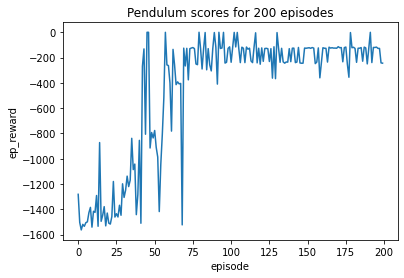

In [46]:
train()

NameError: name 'all_rewards' is not defined

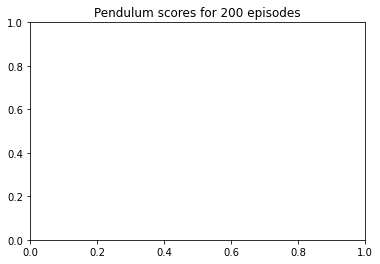